In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
# import pickle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-13 17:28:40.674178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define variables for the "Dataset" and "labels.csv" paths, and variables to determine the testing-data ratio and image dimensions

In [17]:
path = "/home/omar/GP_WS/traffic_sign_recognition/train_dir/train" 
labelFile = '/home/omar/GP_WS/labels.csv'
# A batch size of 32 means that the model will process 32 images in each step during training.
batch_size_val = 32
''' Setting epochs_val = 10 means that the model will iterate over the entire dataset 10 times 
during training to learn the patterns in the data.'''
epochs_val = 50
# Resize each image to be 32x32 and have 3 channels (RGB: Red Green Blue)
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2 



# Collecting images from the dataset and convert into numpy array format

In [6]:
count = 0                   # counter used to track the current class
images = []                 # list to hold all the images from the dataset
classNo = []                # list to hold the class label (integer) corresponding to each image
myList = os.listdir(path)   # list containing the names of all folders inside the dataset directory
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range (0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count)+ "/" + y)
        resized_img = cv2.resize(curImg,  (32,32))
        images.append(resized_img)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 48
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47  


# Split data into 80% training and 20% testing, then split training data into 80% training and 20% validation.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [8]:
print("Data Shapes")
print("Train",end = ""); print(X_train.shape, y_train.shape)
print("Validation",end = ""); print(X_validation.shape, y_validation.shape)
print("Test",end = ""); print(X_test.shape, y_test.shape)

Data Shapes
Train(27679, 32, 32, 3) (27679,)
Validation(6920, 32, 32, 3) (6920,)
Test(8650, 32, 32, 3) (8650,)


In [9]:
data = pd.read_csv("/home/omar/GP_WS/labels.csv")
print("data shape ", data.shape, type(data))

data shape  (48, 2) <class 'pandas.core.frame.DataFrame'>


# Define Functions for Image Preprocessing
*grayscale*: Converts a color image in BGR format(Blue, green, red) to a grayscale image.

*equalize*: Enhances the contrast of a grayscale image by applying histogram equalization.

*preprocessing*: Prepare the image for model training by normalize the pixels to be from 0 to 1 instead of 0 to 255

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     
    img = equalize(img)      
    img = img/255            
    return img

# Preprocessing all the images in training, validation, and testing sets

In [11]:
X_train = np.array(list(map(preprocessing, X_train)))  
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# This section of the code uses Keras's ImageDataGenerator class to augment the training images

# Importance of Data Augmentation:
### 1- Improved Generalization
### 2- Handling Limited Data
### 3- Increased Model Robustness
### 4- Real-time Processing

In [13]:
# It helps improve the model's generalization ability by artificially expanding 
# the size of the training dataset through various transformations.
dataGen = ImageDataGenerator(width_shift_range=0.1,   #This randomly shifts the image horizontally by up to 10% of its width
                            height_shift_range=0.1,   #This randomly shifts the image vertically by up to 10% of its height
                            zoom_range=0.2,           #This applies a random zoom to the image, with a zoom factor ranging from 0.8 to 1.2 (20% zoom)
                            shear_range=0.1,          #This applies a random shear transformation (distorting the image along an axis)
                            rotation_range=0)        #This randomly rotates the image by up to 10 degrees
dataGen.fit(X_train)
# It takes the training images (X_train) and their corresponding labels (y_train),
# and outputs them in batches of size 20.
batches = dataGen.flow(X_train, y_train, batch_size=32)
X_batch, y_batch = next(batches)

# Convert integer labels into a one-hot encoded format.

In [14]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [15]:
def myModel():
    model = Sequential()
    '''60: The number of filters (or kernels) to use in this convolutional layer.
    (5, 5): The size of each filter (5 pixels by 5 pixels).
    input_shape=(imageDimesions[0], imageDimesions[1], 1): Specifies the shape of the input data.
    In this case, it's a grayscale image (1 channel) with dimensions 32x32 pixels.
    activation='relu': The activation function used to introduce non-linearity. 
    The Rectified Linear Unit (ReLU) activation function helps to alleviate the vanishing gradient problem.'''
    model.add(Input(shape=(imageDimesions[0], imageDimesions[1], 1)))
    # This layer learns to detect features (like edges or textures) in the input images.
    model.add((Conv2D(60, (5,5), activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    # Adds another convolutional layer with the same number of filters and filter size.
    # This helps in capturing more complex patterns in the image.
    model.add((Conv2D(60, (5,5), activation='relu')))
    # This layer reduces the spatial dimensions (height and width) of the input volume.
    model.add(MaxPooling2D(pool_size=(2,2)))
    # These lines add two more convolutional layers, each with 30 filters and a 3x3 filter size,
    # followed by another max pooling layer.
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # The Dropout(0.5) layer is used to prevent overfitting by randomly setting 50% of 
    # the input units to zero during training.
    model.add(Dropout(0.5))
    # This layer flattens the 2D matrices into a 1D vector, which is necessary before
    # connecting to the fully connected (Dense) layers.
    model.add(Flatten())
    # The first Dense layer has 500 neurons and uses the ReLU activation function.
    # This layer combines the features learned in the previous layers to make predictions
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    # activation='softmax': The softmax activation function is used for multi-class classification.
    # It outputs probabilities for each class, summing to 1.
    model.add(Dense(noOfClasses, activation='softmax'))
    # model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    '''Adam(lr=0.001): The Adam optimizer is used to minimize the loss function. 
    The learning rate is set to 0.001.
    loss='categorical_crossentropy': This loss function is suitable for multi-class 
    classification problems with one-hot encoded labels.
    metrics=['accuracy']: The model's performance will be evaluated based on accuracy
     during training and validation.'''
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = myModel()
print(model.summary())
history = model.fit(dataGen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train)//32, epochs=epochs_val, validation_data=(X_validation, y_validation), shuffle=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │        24,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,528 (1.45 MB)

 Trainable params: 380,528 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.0959 - loss: 3.5813 - val_accuracy: 0.6126 - val_loss: 1.4570
Epoch 2/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - accuracy: 0.3125 - loss: 2.3925 - val_accuracy: 0.6150 - val_loss: 1.4654
Epoch 3/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4459 - loss: 1.9377 - val_accuracy: 0.7975 - val_loss: 0.7509
Epoch 4/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - accuracy: 0.6250 - loss: 1.3412 - val_accuracy: 0.8019 - val_loss: 0.7367
Epoch 5/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5970 - loss: 1.3702 - val_accuracy: 0.8691 - val_loss: 0.4813
Epoch 6/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.6875 - loss: 0.9352 - val_accuracy: 0.8714 - val_loss: 0.4773
Epoch 7/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6738 - loss: 1.1005 - val_accuracy: 0.8792 - val_loss: 0.4039
Epoch 8/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.6250 - loss: 1.48

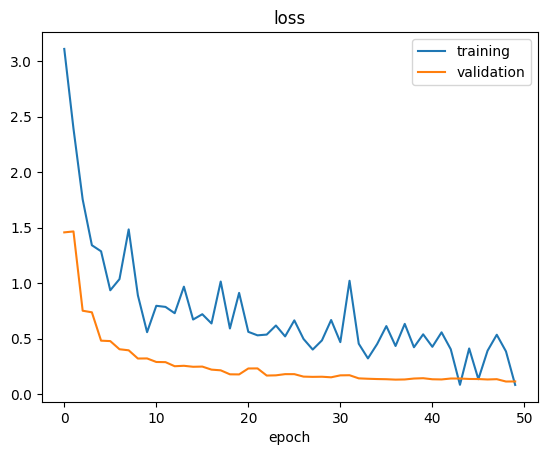

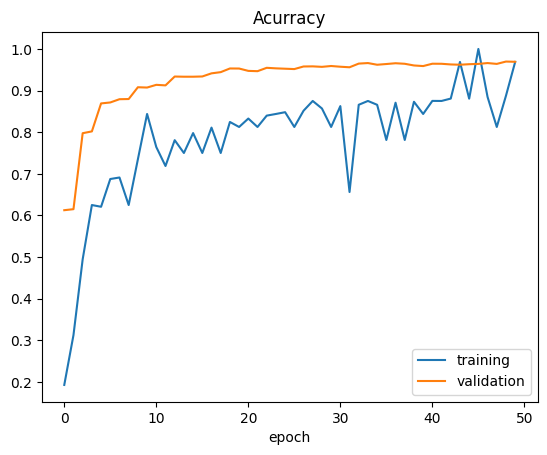

2025-04-13 17:50:39.550928: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,60,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,1,32,32]{3,2,1,0}, f32[60,1,5,5]{3,2,1,0}, f32[60]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-13 17:50:39.563230: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,60,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,60,28,28]{3,2,1,0}, f32[60,60,5,5]{3,2,1,0}, f32[60]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

Test Score: 0.09999004006385803
Test Accuracy: 0.9736416339874268


In [19]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

# Save the Model

In [20]:
model.save("model.keras")